# Natural Language Processing - Text Information Extraction - Sequences - Hidden Markov Models

## Table of Contents
* [Introduction](#Introduction)
* [Requirements](#Requirements)
  * [Knowledge](#Knowledge)
  * [Modules](#Python-Modules)
  * [Data](#Data)
* [Hidden Markov Models](#Hidden-Markov-Models)
  * [From Markov Chains to Hidden Markov Models](#From-Markov-Chains-to-Hidden-Markov-Models)
  * [Properties](#Properties)
  * [Overview of Components](#Overview-of-Components)
* [Exercises](#Exercises)
  * [Encoding the Data](#Encoding-the-Data)
  * [Sample Function](#Sample-Function)
  * [Forward Algorithm](#Forward-Algorithm)
  * [Numerically Stable Forward Algorithm](#Numerically-Stable-Forward-Algorithm)
  * [Viterbi-Algorithm](#Viterbi-Algorithm)
  * [Total Data Likelihood](#Total-Data-Likelihood)
  * [Backward Algorithm](#Backward-Algorithm)
  * [Gamma Probability](#Gamma-Probability)
  * [Baum Welch Algorithm](#Baum-Welch-Algorithm)
* [Summary](#Summary)
* [Literature](#Literature)
* [Licenses](#Licenses)

## Introduction

> You are climatologists in the year 2799, studying the history of global warming.  You can’t find any records of Baltimore weather, but you do find my diary,  in which I assiduously recorded how much ice cream I ate each day [..]. What can you figure out from this about the weather that summer? - Jason Eisner [[EIS02](#EIS02) p.3]


This notebook deals with Hidden Markov Models (HMMs). A Hidden Markov Model describes a sequence of observed events, emitted from an underlying sequence of hidden states. Throughout this notebook, you will 
* compute the likelihood of sequences
* decode the best hidden sequence given the observations, i.e. figure out the most likely weather sequence given the log of ice cream
* estimate HMM parameters to fit observed data, i.e. estimate the likelihood of weather transitions and ice cream consumption from just the log of ice cream

## Requirements

### Knowledge
Chaper 8 and Appendix A of [Speech and Language Processing](https://web.stanford.edu/~jurafsky/slp3/) by Jurafsky/Martin [[JUR18]](#JUR18) discusses Markov Chains and Hidden Markov Models in depth and presents the algorithms you will implement in the exercises.

Another suitable source for knowledge about Hidden Markov Models are the [course notes](http://www.cs.columbia.edu/~mcollins/hmms-spring2013.pdf) of Michael Collins [[COL13]](#COL13)

So you have to work through the chapters carefully to be prepared to solve the exercises of this notebook.

### Python Modules

In [ ]:
import numpy as np

### Data

This cells sets up various functions for testing. Skip them during reading.

In [ ]:
def test_HMM_and_data():
    A = np.array([[0.0,0.5,0.5,0.0],  # from start
              [0.0,0.8,0.1,0.1],  # from cold
              [0.0,0.1,0.8,0.1],  # from hot
              [0.0,0.0,0.0,1.0]])  # from end
    A_desc = ["start", "cold", "hot", "end"]
    B = np.array([
                [0.0,0.0,0.0], # from start
                [0.7,0.2,0.1],  # from cold
                [0.1,0.2,0.7],  # from hot
                [0.0,0.0,0.0]] # from end
                )
    B = B[1:-1]
    B_desc = ["one", "two", "three"]
    # data for tests
    x = np.array([2, 3, 3, 2, 3, 2, 3, 2, 2, 3, 1, 3, 3, 1, 1, 1, 2, 1, 1, 1, 3, 1, 2,
           1, 1, 1, 2, 3, 3, 2, 3, 2, 2], dtype=int)
    x = x-1
    return A,B,x

def test_sample_sequence(A,B,hidden=None, observed=None):
    assert hidden[0] == 0, "The first element in the hidden state should be 0 (START)"
    assert hidden[-1] == A.shape[0]-1, "The last element in the hidden state sequences should be the last index of A (END)"
    assert len(hidden) == len(observed)+2, "The hidden sequence should be 2 elements longer than the observed sequence, since it includes a START and END state without observations."


def test_forward_algo(forward_algorithm):
    A,B,x = test_HMM_and_data()
    prob, trellis = forward_algorithm(A, B, x)
    np.testing.assert_almost_equal(prob, 9.1276e-19, 22)
    np.testing.assert_almost_equal(trellis[0,0],  0.1,        4)
    np.testing.assert_almost_equal(trellis[2,0],  0.00135,    5)
    np.testing.assert_almost_equal(trellis[5,0],  8.71549e-5, 9)
    np.testing.assert_almost_equal(trellis[12,0], 5.70827e-9, 9)
    np.testing.assert_almost_equal(trellis[19,0], 1.3157e-10, 14)
    np.testing.assert_almost_equal(trellis[26,0], 3.1912e-14, 13)
    np.testing.assert_almost_equal(trellis[32,0], 2.0498e-18, 22)
    np.testing.assert_almost_equal(trellis[0,1],  0.1,        4)
    np.testing.assert_almost_equal(trellis[2,1],  0.03591,    5)
    np.testing.assert_almost_equal(trellis[5,1],  5.30337e-4, 8)
    np.testing.assert_almost_equal(trellis[12,1], 1.37864e-7, 11)
    np.testing.assert_almost_equal(trellis[19,1], 2.7819e-12, 15)
    np.testing.assert_almost_equal(trellis[26,1], 4.6599e-15, 18)
    np.testing.assert_almost_equal(trellis[32,1], 7.0777e-18, 22)

    
def test_viterbi(viterbi_algorithm):
    A,B,x = test_HMM_and_data()
    trellis, trace = viterbi_algorithm(A, B, x)
    
    assert trace == [0] + [2]*13 + [1]*14 + [2]*6 + [3]
     # with adjusted indices
    np.testing.assert_almost_equal(trellis[0][1],  0.1,      4)
    np.testing.assert_almost_equal(trellis[5][1],  5.62e-05, 7)
    np.testing.assert_almost_equal(trellis[6][1],  4.50e-06, 8)
    np.testing.assert_almost_equal(trellis[15][1], 1.99e-09, 11)
    np.testing.assert_almost_equal(trellis[16][1], 3.18e-10, 12)
    np.testing.assert_almost_equal(trellis[22][1], 4.00e-13, 15)
    np.testing.assert_almost_equal(trellis[24][1], 1.26e-13, 15)
    np.testing.assert_almost_equal(trellis[28][1], 7.20e-17, 19)
    np.testing.assert_almost_equal(trellis[29][1], 1.15e-17, 19)
    np.testing.assert_almost_equal(trellis[31][1], 7.90e-19, 21)
    np.testing.assert_almost_equal(trellis[32][1], 1.26e-19, 21)
    np.testing.assert_almost_equal(trellis[0][2], 0.1,      4)
    np.testing.assert_almost_equal(trellis[3][2], 0.00502,  5)
    np.testing.assert_almost_equal(trellis[5][2], 0.00045,  5)
    np.testing.assert_almost_equal(trellis[11][2], 1.62e-07, 9)
    np.testing.assert_almost_equal(trellis[17][2], 3.18e-12, 14)
    np.testing.assert_almost_equal(trellis[18][2], 1.78e-12, 14)
    np.testing.assert_almost_equal(trellis[22][2], 5.00e-14, 16)
    np.testing.assert_almost_equal(trellis[27][2], 7.87e-16, 18)
    np.testing.assert_almost_equal(trellis[28][2], 4.41e-16, 18)
    np.testing.assert_almost_equal(trellis[29][2], 7.06e-17, 19)
    np.testing.assert_almost_equal(trellis[32][2], 1.01e-18, 20)
    
    
def test_backward_algo():
    A,B,x = test_HMM_and_data()
    prob, trellis = backward_algorithm(A, B, x)
    np.testing.assert_almost_equal(prob, 9.1276e-19, 21)
    np.testing.assert_almost_equal(trellis[0][0],  1.1780e-18, 22)
    np.testing.assert_almost_equal(trellis[2][0],  7.2496e-18, 22)
    np.testing.assert_almost_equal(trellis[5][0],  3.3422e-16, 20)
    np.testing.assert_almost_equal(trellis[12][0], 3.5380e-11, 15)
    np.testing.assert_almost_equal(trellis[19][0], 6.77837e-9, 14)
    np.testing.assert_almost_equal(trellis[26][0], 1.44877e-5, 10)
    np.testing.assert_almost_equal(trellis[32][0], 0.1,        4)
    np.testing.assert_almost_equal(trellis[0][1],  7.9496e-18, 22)
    np.testing.assert_almost_equal(trellis[2][1],  2.5145e-17, 21)
    np.testing.assert_almost_equal(trellis[5][1],  1.6662e-15, 19)
    np.testing.assert_almost_equal(trellis[12][1], 5.1558e-12, 16)
    np.testing.assert_almost_equal(trellis[19][1], 7.52345e-9, 14)
    np.testing.assert_almost_equal(trellis[26][1], 9.66609e-5, 9)
    np.testing.assert_almost_equal(trellis[32][1], 0.1, 4)

    
def test_total_data_likelihood(fn):
    A,B,x = test_HMM_and_data()
    z = np.array([0] + [2]*13 + [1]*14 + [2]*6 + [3])
    np.testing.assert_almost_equal(fn(A,B,x,z), 1.0114871426573873e-19)
    
    
def test_backward_algo(fn):
    A,B,x = test_HMM_and_data()
    prob, trellis = fn(A, B, x)
    np.testing.assert_almost_equal(prob, 9.1276e-19, 21)
    np.testing.assert_almost_equal(trellis[0][0],  1.1780e-18, 22)
    np.testing.assert_almost_equal(trellis[2][0],  7.2496e-18, 22)
    np.testing.assert_almost_equal(trellis[5][0],  3.3422e-16, 20)
    np.testing.assert_almost_equal(trellis[12][0], 3.5380e-11, 15)
    np.testing.assert_almost_equal(trellis[19][0], 6.77837e-9, 14)
    np.testing.assert_almost_equal(trellis[26][0], 1.44877e-5, 10)
    np.testing.assert_almost_equal(trellis[32][0], 0.1,        4)
    np.testing.assert_almost_equal(trellis[0][1],  7.9496e-18, 22)
    np.testing.assert_almost_equal(trellis[2][1],  2.5145e-17, 21)
    np.testing.assert_almost_equal(trellis[5][1],  1.6662e-15, 19)
    np.testing.assert_almost_equal(trellis[12][1], 5.1558e-12, 16)
    np.testing.assert_almost_equal(trellis[19][1], 7.52345e-9, 14)
    np.testing.assert_almost_equal(trellis[26][1], 9.66609e-5, 9)
    np.testing.assert_almost_equal(trellis[32][1], 0.1, 4)
    
    
def test_e_step(func):
    A,B,x = test_HMM_and_data()
    gamma,xi,likelihood = func(A,B,x)
    
    # test gamma row sums
    msg = "All rows in gamma should sum to 1"
    actual = gamma.sum(axis=1)
    np.testing.assert_allclose(actual, np.ones_like(actual),err_msg=msg)
    
    # xi i->j (not start/end should be all zeros)
    msg = "xi[0,:,:] represents the start of the sequence. Only transitions from "
    msg += "START to a state should be non-zero here"
    actual = xi[0,1:-1,1:-1]
    desired = np.zeros_like(actual)
    np.testing.assert_allclose(actual,desired, err_msg=msg)
    
    # start probabilities should sum to one
    actual = xi[0,0,1:-1].sum()
    np.testing.assert_almost_equal(actual,1)
    
    # xi end should be z -> end
    msg = "xi[-1,:,:] represents the end of the sequence. Only transitions from states"
    msg += " to END should be non-zero."
    actual = xi[-1,1:-1,1:-1]
    np.testing.assert_allclose(actual,np.zeros_like(actual),err_msg=msg)
    
    # xi end probs should be 1
    msg = "Transitions to END in xi[-1,:,:] should sum to 1. since the sequence surely"
    msg += " ends."
    actual = xi[-1,:,-1].sum()
    np.testing.assert_almost_equal(actual,1,err_msg=msg)
    
    # test some values in the body
    desired_xi2 = np.zeros((4,4))
    desired_xi2[1:-1,1:-1] = [[0.00572, 0.01736], [0.005, 0.97192]]
    np.testing.assert_allclose(xi[2], desired_xi2, atol=1e-5)
    
    desired_xi13 = np.zeros((4,4))
    desired_xi13[1:-1,1:-1] = [[2.20678e-01, 5.82381e-04], [6.66216e-01, 1.12524e-01]]
    np.testing.assert_allclose(xi[13], desired_xi13, atol=1e-5)
    
    np.testing.assert_allclose(gamma[1],[0.02307, 0.97693],atol=1e-5)
    np.testing.assert_allclose(gamma[14],[0.97972, 0.02028],atol=1e-5)
    np.testing.assert_allclose(gamma[30],[0.04471, 0.95529],atol=1e-5)
    
def test_m_step(efunc,mfunc):
    A,B,_ = test_HMM_and_data()
    X = [[1, 2, 1, 2, 1, 2, 2, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 2], [0, 2, 2, 0, 0], [0]]
    ga = np.concatenate([efunc(A,B,x)[0] for x in X])
    xa = np.concatenate([efunc(A,B,x)[1] for x in X])
    A_pred, B_pred = mfunc(ga,xa,X,B.shape[1])
    
    # shapes must match
    assert A.shape == A_pred.shape, "Shape of fitted A does not match shape of true A"
    assert B.shape == B_pred.shape, "Shape of fitted B does not match shape of true B"
    
    # test validity of A and B
    msg = "A does not seem to be a valid transition matrix."
    actual = A_pred.sum(axis=1)
    np.testing.assert_allclose(actual,np.ones_like(actual),err_msg=msg)
    
    msg = "B does not seem to be valid observation probabilities."
    actual = B_pred.sum(axis=1)
    np.testing.assert_allclose(actual,np.ones_like(actual),err_msg=msg)
    
    # test values
    np.testing.assert_allclose(A_pred[0], [0., 0.55131, 0.44869, 0.],5)
    np.testing.assert_allclose(A_pred[1], [0., 0.83557, 0.07308, 0.09135],5)
    np.testing.assert_allclose(A_pred[2], [0., 0.1583, 0.74347, 0.09823],5)
    np.testing.assert_allclose(A_pred[3], [0., 0.,   0.,   1.],1)
    np.testing.assert_allclose(B_pred[0], [0.81538, 0.12816, 0.05645],5)
    np.testing.assert_allclose(B_pred[1], [0.09149, 0.29802, 0.61049],5)

# Hidden Markov Models

### From Markov Chains to Hidden Markov Models

Recap: Markov Models

A **Markov Chain** models a sequence of states $z_1 \dots z_T$ or equivalently $z_{1:T}$. Each state $z_t$ represents a random variable that takes on a value from a vocabulary of states at time $t$. A transition matrix $A$ where $A_{ij}$ is the probability of moving from state $i$ to state $j$.

Example: We're on a vacation. Each day, the state of the weather can be sunny, cloudy or raining. In our diary, we note down today's weather.

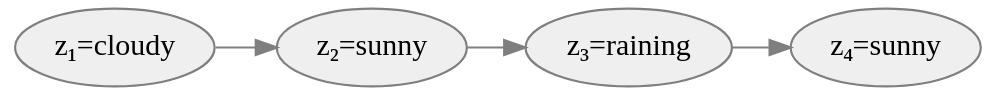



In a **Hidden Markov Model**, this sequence of states exists but we don't observe it directly, it is **hidden**. At each time point $t$ of the sequence, we observe an event $x_t$ (also called an emission) emitted from the state $z_t$. This produces a sequence of hidden states $z_{1:T}$ and a matching sequence of observed events $x_{1:T}$.

Example: On each day of our vacation, we choose an activity from either hiking, going to the beach or visiting the museum. In our diary, we note down today's activity but not the weather.

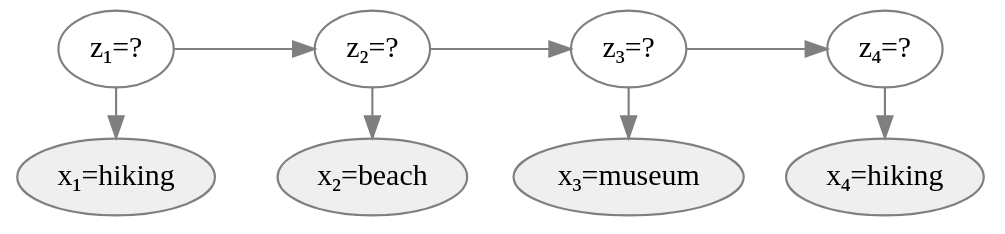

### Properties
There are two important properties here:

* **Markov property:** The probability of the current state depends only on the direct predecessor state, and no further previous states or observations.
$$
p(z_{t+1} \mid z_{1:t}) = p(z_{t+1} \mid z_{t})
$$


* **Output independence:** The probability of an observation depends only on the current state, and no previous states or observations.
$$
p(x_{t} \mid z_{1:t}, x_{1:t}) = p(x_{t} \mid z_t)
$$

with the abbreviation
$z_{1:t}= z_1, z_2, \dots, z_t $


### Overview of Components

* A sequence of discrete hidden states $z_{1:T}$, here we use indices for the states, i.e. $z_t \in \{1,2,\dots K\}$ 
 - $K$ is the number of different hidden states
* A sequence of observations $S = x_{1:T} = x_1, x_2, \dots ,x_t ,\dots, x_T$  
*  The number of time steps of a sequence is $T$

### Transition Matrix $A$
Matrix $A$ encodes the probability for the 
transitions $(z_{t-1}=i)\rightarrow (z_t=j)$:

$$
\forall t : A_{i,j} := p( z_t=j \mid z_{t-1}=i )
$$

with 
- $\forall i : \sum_j A_{i,j}=1$

The transition probabilities are constant over time (stationarity).

### Emission probabilities
$$
p(x_t \mid z_t = i)
$$
If the observations are discrete we can use an observation matrix $B$ with elements
$$
p(x_t = l | z_t = i) = B_{il}
$$
The emission probabilities are constant over time (stationary).

We denote all parameters with $\theta = \{A, B\}$

### Start States
There are different conventions to represent the distribution over the start states $t=1$.

One way is to use an explicit notation for the start distribution:
$$
\pi(z) = p(z_{t=1})
$$

Another convention uses a special start state $z_0 = start$ and encodes the distributions of $z_{t=1}$ in the matrix $A$ (in the elements $A_{0,j}$).

With start state $z=0$ we make the following assertions about the transition matrix:
* $A_{0j}$ is equivalent to the start distribution $\pi$
* $\forall i: A_{i0}$ = 0, there are no transitions to the start state.

### End States
There are different kinds of Markov Chains:
 - fixed length
 - variable length
 
For the variable length Markov Chains we need a probability at each time step $t$
that the chain ends.
Either we use an explicit end probability $p_{end}$ and $1-p_{end}$ for the probability that the chain proceeds.

Or we use a special end state (last index: $K'=K+1$) and encode the end probability in the matrix $A$ (in the elements $A_{iK}$).

A hidden markov model with sequence length $T=4$, including the $start$ and $end$ state looks like the following:

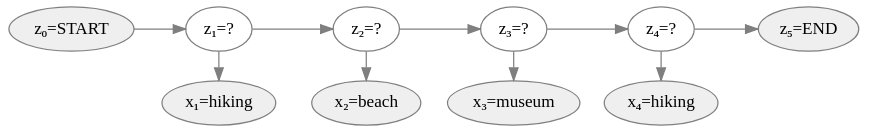

Note the hidden sequence starts with $t=0$ and ends with $t=T+1$.

### Problems

Rabiner's Tutorial on Hidden Markov Models \[RAB89\] outlines the three fundamental problems associated with Hidden Markov Models. 


>**Problem 1: Likelihood** Given an HMM $\theta = \{A,B\}$ and an observation sequence $x_{1:T}$, determine the likelihood $p(z_{1:T} \mid \theta)$

>**Problem 2: Decoding** Given an observation sequence $x_{1:T}$, determine the most probable hidden state sequence $z_{1:T}$.

>**Problem 3: Learning** Given  a set of observation sequences $x_{1:T}$ and a set of possible states, learn the HMM parameters $A$ and $B$.

Throughout these exercises, you will first encode our vacation example into an HMM.
Then, you will compute the **forward** and **backward probability** (also known as $\alpha$ and $\beta$ probability) to assess the likelihood of data for a given HMM. (Problem 1)

Next, you will implement the **Viterbi Algorithm** to decode the best hidden state sequence (Problem 2).

Finally, you will tackle Problem 3. You will use your implementations of the forward and backward probability. You can then implement the Baum-Welch algorithm to estimate the most likely parameters for an HMM given a list of observation sequences.

## Exercises

### Encoding the Data

The diagram shows a Hidden Markov Model of a vacation example adapted from [[KEL18](#KEL18)].
The left-hand side of the diagram shows the Markov Model describing the transitions between weather states. Remember the state transitions are not directly observed in an HMM.
The right-hand side shows the observation probabilities given the weather state.

**Task:**

* Write the matrices $A$ and $B$ for the vacation example in numpy.
* Encode the start distribution in the matrix $A$ with start state $z=0$.
* Which conditions must hold for the matrices $A$ and $B$? Test if the properties hold.

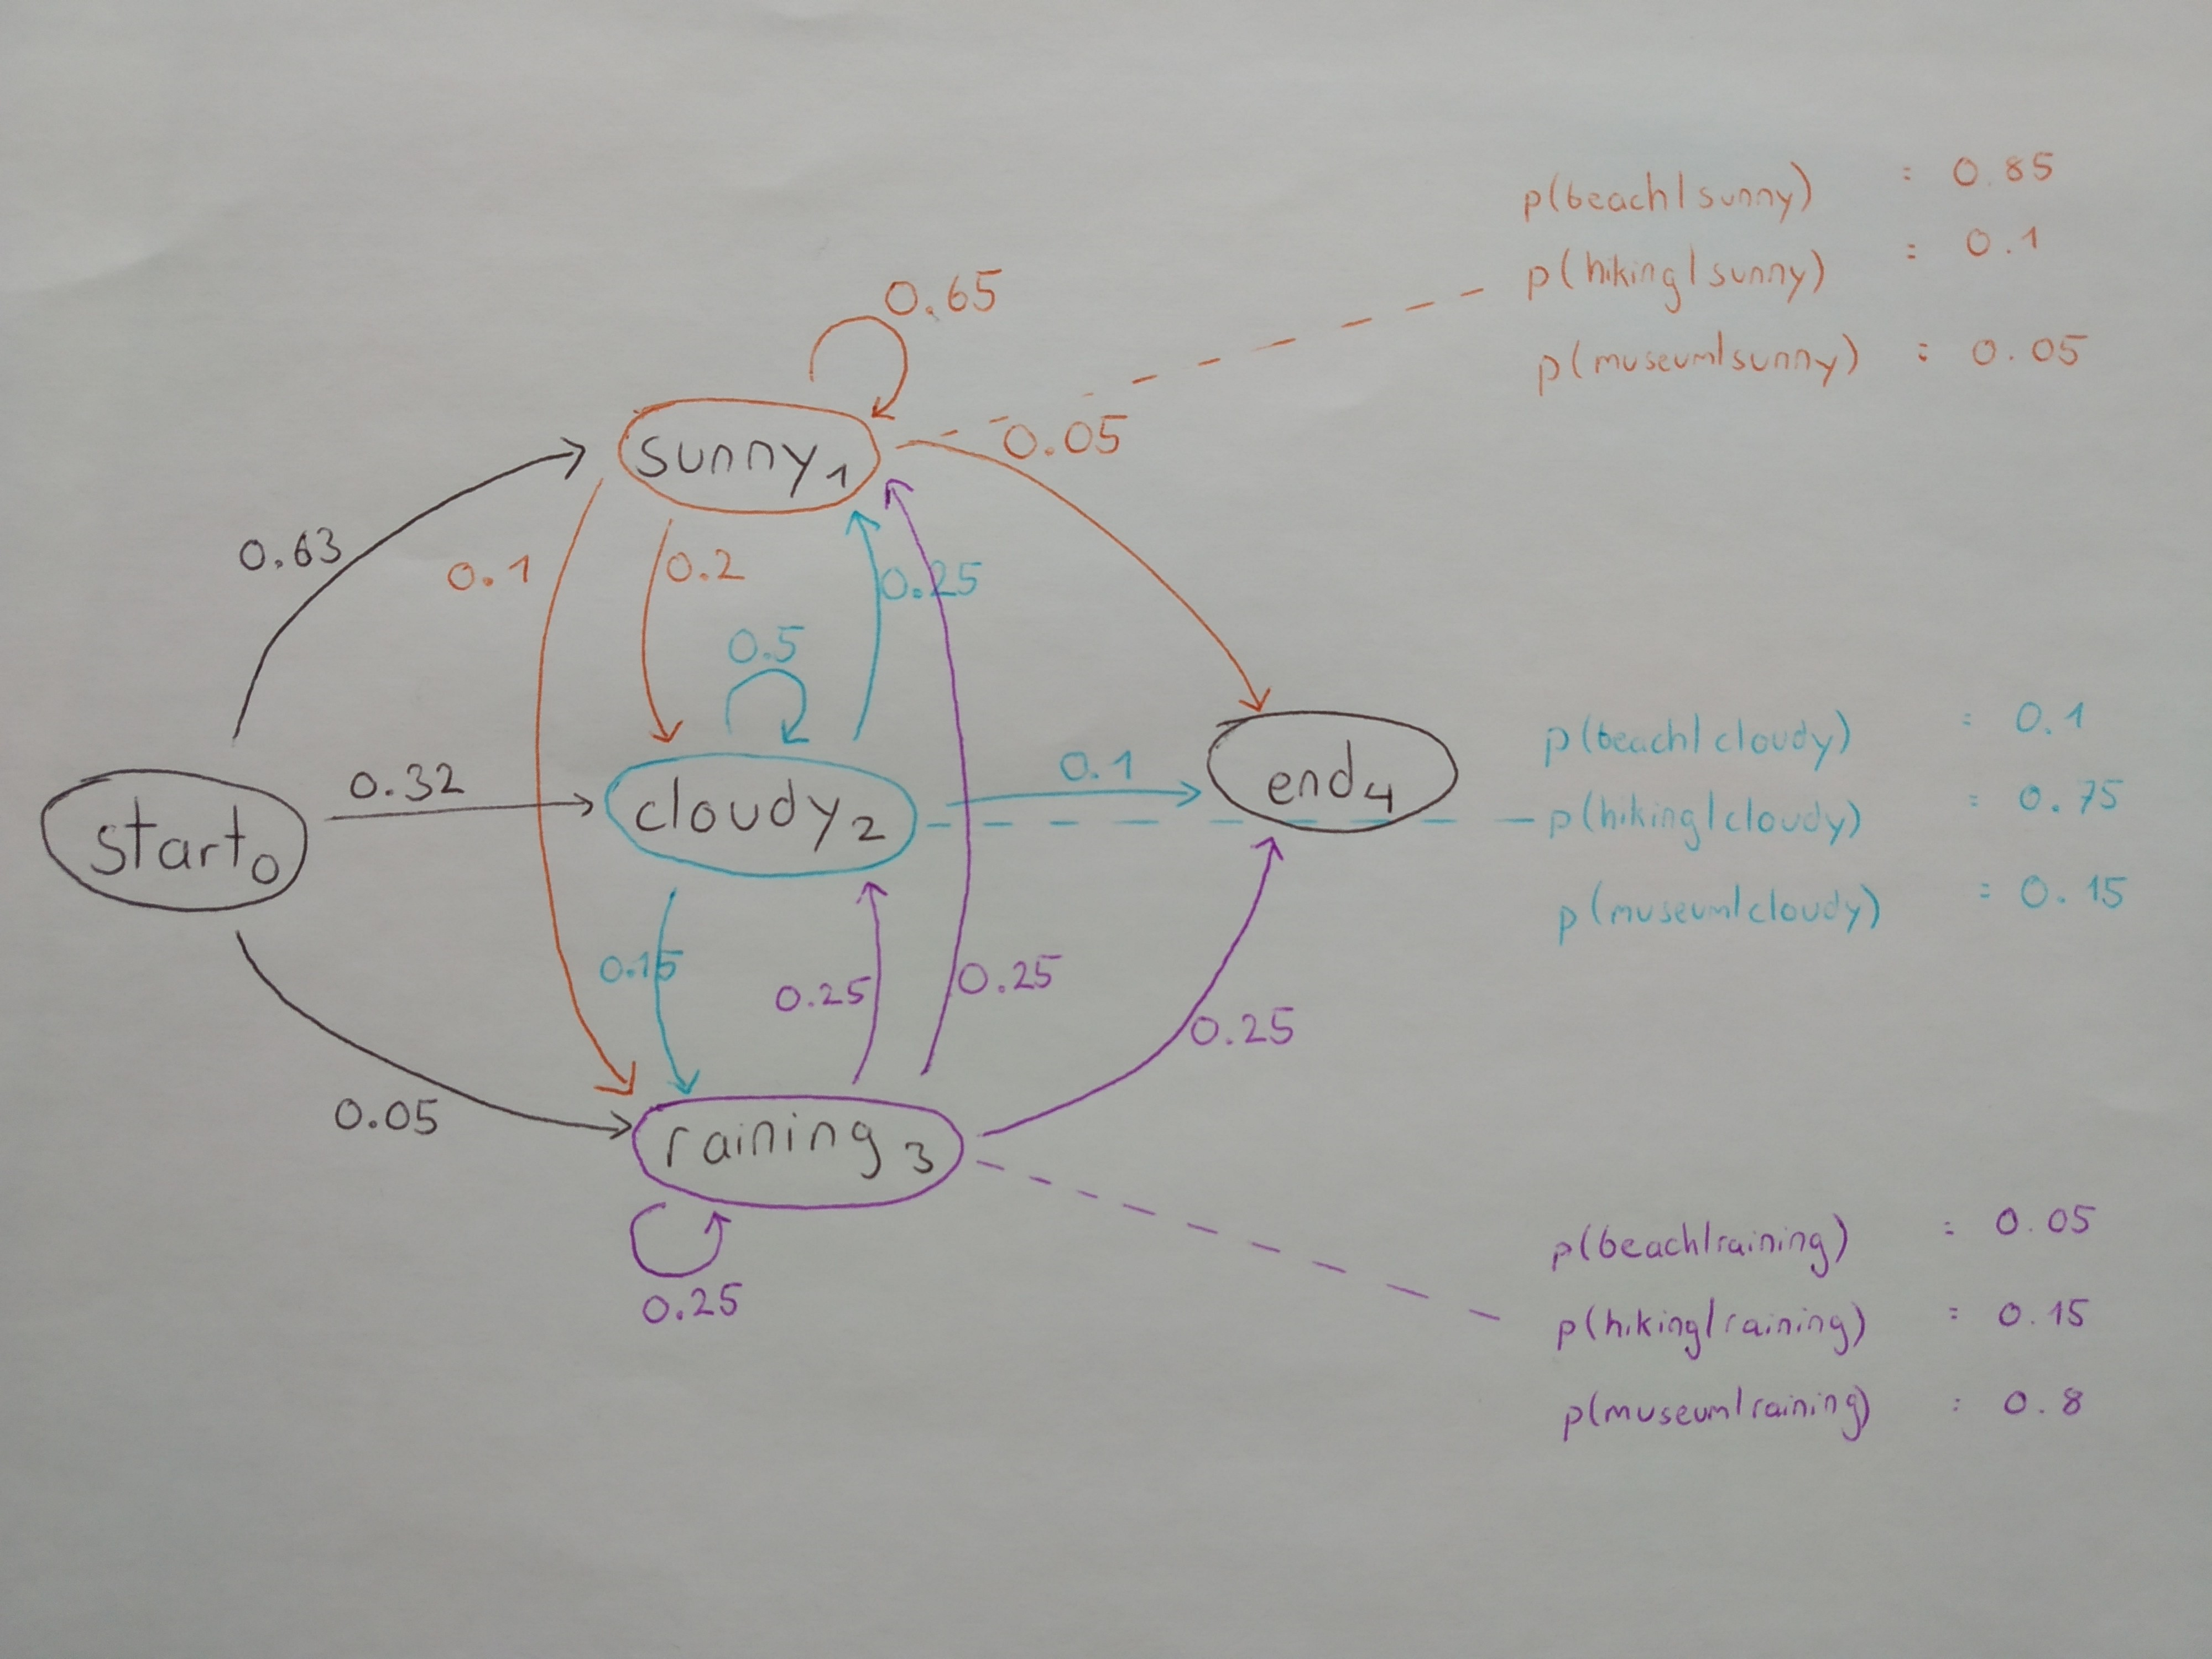

In [ ]:
A_desc = ["start", "sunny", "cloudy", "raining", "end"]
B_desc = ["beach", "hiking", "museum"]
A = None # as exercise
B = None # as exercise

### Sample Function

**Task:**

Sample a hidden state sequence $z$ and a matching observed event sequence $x$ from the HMM. The hidden state sequence should start with 0 (the START state) and end with the final index in A (the END state).

**Hint:**

* Sample until you draw the end state.
* You can use [np.random.multinomial](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.multinomial.html) combined with np.argmax to pick an item from a multinomial distribution, e.g. to roll a dice:

`1 + np.argmax(np.random.multinomial(1, [1./6., 1./6., 1./6., 1./6., 1./6., 1./6., ]))` 

or just:

`1 + np.argmax(np.random.multinomial(1, [1./6.]*6))`

**Note**: Make sure you keep your indexing consistent. The first row of $A$ encodes the special START state while the first row of $B$ encodes the _sunny_ weather state.

One approach would be to create $B\_$ which encodes the START and END state with observation probabilities 0 (there are no observations at START/END).
Another would be a helper matrix $A\_$ which is a subset of $A$ without the START/END state.

Throughout these exercises you'll likely find one or the other (or both) approaches useful, depending on the current task.

In [ ]:
def sample_from_HMM(A, B):
    # returns z, x (as 1-d numpy arrays)
    # the elements of z and x are the indices of the corresponding states  
    z = [0] # 0 corresponds to start
    x = [] # for start there is no activity (observation)
    
    raise NotImplementedError()
    return z, x

In [ ]:
z,x = sample_from_HMM(A,B)
print([A_desc[i] for i in z])

In [ ]:
print([B_desc[i] for i in x])

Your implementation should pass the following test (defined in [Data](#Data)). If it passes the test, the cell output is empty, otherwise it shows a traceback of the failure.

In [ ]:
test_sample_sequence(A,B,hidden=z,observed=x)

### Forward Algorithm

The forward probability $\alpha_{t,j}$ tells us the probability of being in state $j$ at time step $t$ given the observed sequence $x_{1:t}$ up to time step $t$ and the parameters $A$ and $B$ of the HMM. 

$$
\alpha_{t, j} := p(x_1, x_2, \dots, x_t, z_t=j \mid  \theta)
$$
with
- the observation sequence $x_1, \dots, x_t$
- parameters of the HMM $\theta =\{A, B\}$ 
- the number of different hidden states $K'$ (including start and end state) or $K$ with $K'=K+2$ (from start state $0$ to end state $K+1$).


The computation of $\alpha_{t,j}$ can be efficiently implemented by a dynamic programming approach with complexity $O(K^2 T)$. We divide the algorithm into an initialisation, recursion and finalisation step and store the intermediate results in a table.


#### 1. Initialisation
For the alpha probabilities of the first time step we multiply
* the initial probability of state $j$ at $t=1$ with
* the observation probability of the first emission $x_{1}$ ($t=1$) given $z_1=j$

$$
\alpha_{1, j} = p(z_1 = j \mid z_0=0) p(x_1 = k \mid z_1=j) = A_{1j} B_{j,k=x_1}
$$


#### 2. Recursion

The recursion step goes ahead a step forward in the sequence. 

By the sum and product rule we have
$$
\begin{align}
\alpha_{t, j} &= p(x_1, x_2, \dots, x_t, z_t=j \mid  \theta) \\
&= \sum_i^K p(x_1, x_2, \dots, x_{t-1}, x_t, z_{t-1}=i, z_t=j;\theta)\\
&= \sum_i^K p(x_1, x_2, \dots, x_{t-1}, z_{t-1}=i \mid  \theta) p(x_t, z_t=j \mid x_1, x_2, \dots, x_{t-1}, z_{t-1}=i; \theta)\\
&= \sum_i^K p(x_1, x_2, \dots, x_{t-1}, z_{t-1}=i \mid  \theta) p(x_t \mid x_1, x_2, \dots, x_{t-1}, z_{t-1}=i, z_t=j;\theta)
p(z_t=j \mid x_1, x_2, \dots, x_{t-1}, z_{t-1}=i; \theta)
\end{align}
$$

Now we use the properties of the hidden Markov model:
$$
\begin{align}
\alpha_{t, j} &= \sum_i^K p(x_1, x_2, \dots, x_{t-1}, z_{t-1}=i \mid  \theta) p(x_t \mid z_t=j;\theta) p(z_t=j \mid z_{t-1}=i; \theta)\\
&= \sum_{i=1}^K \alpha_{t-1, i} B_{j,k=x_t} A_{i,j}
\end{align}
$$
In words:

To compute the next forward probability from the previous one we need have consider every possible path we could have taken through the hidden sequence so far.  Then we make a transition to $j$ and observe $x_t$. Thanks to the Markov assumption, we only need to look 1 step into the past. By summing over all the possible previous states $i$ we obtain the forward probability $\alpha_{t,j}$:

$$
\alpha_{t, j} = \sum_{i=1}^K \alpha_{t-1, i} A_{i,j}B_{j,k=x_t} 
$$



#### 3. Finalisation

The $\alpha_{T,j}$ is the forward probability of being in state $j$ at the final time step. 

The likelihood of the entire sequence (with fixed length) is calculated by summing over all states at time $T$.

$$
p(x_{1:T} \mid \theta) =  \sum_{i=1}^K p(x_{1:T}, z_T=i \mid  \theta)=
\sum_{i=1}^K \alpha_{T,i}
$$

If the length of the sequence is not fixed (as in our example) we compute the likelihood by transitions to the end state $z_{T+1}=K+1$:

$$
p(x_{1:T} \mid \theta) = \sum_{i=1}^K p(x_{1:T}, z_T=i \mid \theta) \cdot p(z_{T+1}=K+1 \mid z_{T-1}=i; \theta)= \sum_{i=1}^K \alpha_{T, i} A_{i,z_{T+1}=K+1}
$$

In [ ]:
def forward_algorithm(A, B, x):
    """
    Parameters
    ----------
    A : np.array; dtype=float
        Transition probabilities of the hidden states i->j: $A_{ij}$
    B : np.array; dtype=float
        Observation probabilities from hidden state j to 
        observation index k. i.e. j->k:$B_{jk}$
    x : list of int
        Sequence of observations
    
    Returns
    -------
    likelihood : float
        probability p(x|A, B)
    alpha: np.array, dtype=float
        with entries $alpha_{tj} = p(x_1, .., x_t, z_t=j | A, B)$
        $0\leq t \leq T-1$ with $T$ observations.
    """
    
    # computes the likelihood of the HHM (A,B) given the observation
    # sequence of observations x 
    raise NotImplementedError()
    # Your duty
    return likelihood, alpha

In [ ]:
A,B,x = test_HMM_and_data()
forward_algorithm(A,B,x)

Your implementation should pass the following test.

In [ ]:
test_forward_algo(forward_algorithm)

### Numerically Stable Forward Algorithm

Multiplication of small numbers can result in an underflow error, so it's common to work with log-probabilities:
$$
log(a \cdot b) = log(a) + log(b)
$$

The problem is that the forward algorithm requires us to both multiply and add probabilities. While multiplication of log probabilities is convenient, addition is cumbersome.

The solution is to scale the probability of a vector $v=\alpha_t$ e.g. by `s=1/np.sum(v)` or `s=np.max(v)` to prevent an underflow.


Some caution is required since we're using a dynamic programming approach where we reuse the value of the previous row. Consider what happens when we fill the table top to bottom:

#### No scaling
$$
\begin{align}
Time   && Probability\ \alpha_t \\
t_1    && \alpha_1 \\
t_2    && \alpha_2 \\
t_3    && \alpha_3 \\
\end{align}
$$

#### Scaling
After filling each row, we multiply by some factor $s_t$ e.g. the sum of the row
$$
\begin{align}
Time   && Scaled\ probability\ \hat{\alpha_t} && \\
t_1    && s_1 \cdot             \alpha_1 && \\
t_2    && s_1 \cdot s_2 \cdot       \alpha_2 &&\\
t_3    && s_1 \cdot s_2 \cdot s_3 \cdot \alpha_3 && \\
\end{align}
$$

Since we always read the value of the previous row, we also factor in the scaling factor of the previous row. To recover the true probabilities we must cancel out all the previous scaling factors.

E.g.
$$
\alpha_3 = \frac{\hat{\alpha_3}}{s_1 \cdot s_2 \cdot s_3}
$$

In log space:
$$
\log(\alpha_3) = \log(\hat{\alpha_3}) - \log(s_1) - \log(s_2) - \log(s_3)
$$

Formally:
$$
\log(\alpha_t) = \log(\hat{\alpha_t}) - \sum_{c=1}^t \log(s_c)
$$

#### Exercise: Implementation of the stable forward algorithm

- Implement a numerically stable version of the forward algorithm by scaling as described above. 

In [ ]:
# numerically stable version
def forward_algorithm_(A, B, x):
    """
    Parameters
    ----------
    A : np.array; dtype=float
        Transition probabilities of the hidden states i->j: $A{ij}$
    B : np.array; dtype=float
        Observation probabilities from hidden state j to 
        observation index k. i.e. j->k:$B_{jk}$
    x : list of int
        Sequence of observations 
        
    Returns
    -------
    log likelihood : float
        log of the probability p(x|A, B)
    log alpha: np.array, dtype=float
        with entries $log_alpha_{tj} = \log p(x_0, x_1, .., x_t, z_t=j | A, B)$
        $0\leq t \leq T-1$ with $T$ observations.
    """
    raise NotImplementedError()
    return log_likelihood, log_alpha  

In [ ]:
A,B,x = test_HMM_and_data()
x = [1, 2]

forward_algorithm_(A,B,x)

The two implementations of the forward algorithm should return the same result.

In [ ]:
A,B,x = test_HMM_and_data()
likelihood, alpha = forward_algorithm(A, B, x)
log_likelihood, log_alpha = forward_algorithm_(A, B, x)
np.testing.assert_allclose(log_likelihood, np.log(likelihood))
np.testing.assert_allclose(log_alpha, np.log(alpha))

### Viterbi Algorithm

When you've grasped the forward algorithm it's only a small step to implement the Viterbi algorithm which addresses problem 2 of decoding. The Viterbi Algorithm reveals the most probable hidden state sequence $z_{1:T}$ for a given observed sequence $x_{1:T}$ and the HMM parameters $\theta$.

#### 1. Initialisation
Similarly to the forward algorithm, we multiply the start probability and probability of the first emission for each state $j$.

$$
viterbi_{0, j} = A_{0j} B_{j,k=x_0}\\
backpointer_{0,j} = 0
$$



#### 2. Recursion
The recursion step computes the next viterbi value from the previous ones. Like before, we consider the paths we could have taken so far, move to state $j$ and observe an event.

Unlike before, we don't sum over all previous states $i$. We calculate the likelihood of moving from $i$ to $j$ and observing $z_t$ for every $i$, producing a vector of likelihoods $\vec{v}_i = (v_1, v_2, \dots v_K)$.
In the viterbi table, we store the maximum vector of all vectors $\vec{v}_i$ as the likelihood of the best sequence so far.
In the backpointer, we store the argmax of this $\vec{v}_i$ as a pointer to the previous state on this path.

$$
\vec{v}_i = viterbi_{t-1, i} A_{i,j}B_{j,k=x_t} \\
viterbi_{t,j} = \max_{i=1}^K \vec{v}_i \\
backpointer_{t,j} = \text{arg} \max_{i=1}^K \vec{v}_i
$$

#### 3. Finalisation
Again, we finish by weighting in the end probabilities (Note: here we have no observation, so no multiplication with $B$).

$$
\vec{v}_i = viterbi_{T,i} * A_{i,K}
$$

The likelihood of the best sequence is the maximum vector of our final vectors $\vec{v}_i$.
$$
viterbi_{T+1} = \max_{i=1}^K \vec{v}
$$

We write the argmax of the the maximum $\vec{v}_i$ into the last row of the backpointer.
$$
backpointer_{T+1} = \text{arg} \max_{i=1}^K \vec{v}_i
$$

A sequence of 3 observations may produce the following backpointer.
$$
\begin{align}
0 && \textbf{0} && 0\\
0 && 1 && \textbf{1}\\ 
0 && \textbf{2} && 1\\
1 &&  1 && \textbf{1}\\
\end{align}
$$

We iterate through the rows of the backpointer bottom to top. In each row we obtain the current state and a pointer to the previous state. We repeat this until we reach the beginning of the sequence, which points to the previous state $0$.


In our example we trace the best sequence $0 \rightarrow 1 \rightarrow 2 \rightarrow 1$ and append the special END state $3$.

$$
z_{1:T} = [0,1,2,1,3]
$$

In [ ]:
def viterbi_algorithm(A, B, x):
    """
    Parameters
    ----------
    A : np.array; dtype=float
        Transition probabilities of the hidden states i->j: $A{ij}$
    B : np.array; dtype=float
        Observation probabilities from hidden state j to 
        observation index k. i.e. j->k:$B{jk}$
    x : list of int
        Sequence of observations
        
    Returns
    -------
    v : np.array; dtype=float
        Viterbi table
    trace : list; dtype=int
        The most likely sequence of hidden states z, with a prepended
        START state (0) and appended END state (last index in A)
    """
    raise NotImplementedError()
    return v, trace

In [ ]:
A,B,x = test_HMM_and_data()
v, trace = viterbi_algorithm(A,B,x)
print(v)
print(trace)

In [ ]:
trace

In [ ]:
test_viterbi(viterbi_algorithm) 

### Total Data Likelihood

Compute the total data likelihood of a sequence, i.e.:
$$
 p(x_{1:T}, z_{1:T} \mid \theta=\{A, B\})
$$

Note: Multiplying many probabilities directly together is numerically unstable. If you want to implement a numerically stable version of `total_data_likelihood` you should use log probabilities.

In [ ]:
def total_data_likelihood(A, B, x, z):
    """
    Parameters
    ----------
    A : np.array; dtype=float
        Transition probabilities of the hidden states i->j: $A{ij}$
    B : np.array; dtype=float
        Observation probabilities from hidden state j to 
        observation index k. i.e. j->k:$B{jk}$
    x : list of int
        Sequence of observations
    z : list of int
        Sequence of states
        
    Returns
    -------
    p : float
       Likelihood for observed x and z given A, B
    """
    raise NotImplementedError()

In [ ]:
test_total_data_likelihood(total_data_likelihood)

### Backward Algorithm

The backward probability $\beta$ is defined as

$$
\beta_{t, j} := p(x_{t+1}, x_{t+2}, \dots, x_T\mid z_t=j , \theta) = p(x_{t+1:T}\mid z_t=j , \theta)
$$

Note:
- the $z_t=j$ is now on the "conditioning side" (in comparision to $\alpha_{t, j} = p(x_1, x_2, \dots, x_t, z_t=j \mid  \theta)$)

So the backward probability for the sequence $x_{t+1:T}$ is the probability for the observations from time $t+1$ to the end time $T$,
if we are at $t$ in state $j$ and given the HMM parameters $\theta$.

The implementation is analogous to the forward algorithm.

#### 1. Initialisation
The final row is equivalent to the end probablities.
$$
\beta_{T,i} = A_{i,K}
$$

#### 2. Recursion
In the recursion we weigh in a transition from $i$ to $j$ and the observation $x_{t+1}$ given $j$ and sum for all next states $j$.
$$
\beta_{t, i} = \sum_{j=1}^K \beta_{t+1,j} A_{i,j} B_{j,k=x_{t+1}} 
$$

#### 3. Finalisation
Finally, we weigh in the start probabilities and the probability of the first emission. By summing over all states we obtain the likelihood of the sequence.
<!-- WHAT IS LAMBDA?
$$
P(x \mid \lambda) = \sum_{i=1}^K A_{0,i} \beta_{0,i}
$$
-->
$$
p(x_{1:T} \mid \theta) = \sum_{i=1}^K A_{0,i} \beta_{0,i}
$$

In [ ]:
def backward_algorithm(A, B, x):
    """
    Parameters
    ----------
    A_ : np.array; dtype=float
        Transition probabilities of the hidden states i->j: $A_{ij}$
    B : np.array; dtype=float
        Observation probabilities from hidden state j to 
        observation index k. i.e. j->k:$B_{jk}$
    x : list of int
        Sequence of observations
    
    Returns
    -------
    likelihood : float
        probability p(x|A, B)
    beta: np.array, dtype=float
        with entries $beta_{ti} = p(x_t+1 , x_t+2, .. x_T, z_t=j | A, B)$
        $0\leq t \leq T-1$ with $T$ observations.
    """
    raise NotImplementedError()
    
    return likelihood, beta

In [ ]:
print(backward_algorithm(A,B,x))
test_backward_algo(backward_algorithm)

You now have two approaches to calculate the observation likelihood, you can use either the forward or backward probability.

In [ ]:
A,B,x = test_HMM_and_data()
likelihood_alpha, alpha = forward_algorithm(A,B,x)
likelihood_beta, beta =  backward_algorithm(A,B,x)
print(likelihood_alpha, likelihood_beta)
assert np.isclose(likelihood_alpha,likelihood_beta,atol=1e-20)

### Gamma Probability
We now address the likelihood of a hidden sequence $p(z_t \mid x_{1:T}, \theta)$.
Using the [quotient rule](https://www.princeton.edu/~bayesway/ProbThink/Ch1Part1.html#RTFToC6) we get:
$$
 p(z_t   \mid x_{1:T}; \theta) = \frac{p(z_t , x_{1:T}\mid \theta)}{p( x_{1:T} \mid \theta)}
$$

The denominator is the observation likelihood (calculated either with the forward or backward algorithm).
To solve the numerator, we introduce $\gamma_{t,i}$ as the probability of being in the hidden state $i$ at time point $t$. $\gamma_{t,i}$ factors in the forward and backward probability.
$$
\gamma_{t,i} := p(z_t=i \mid x_{1:T}; \theta) = \frac{\alpha_{t,i} \beta_{t,i}}{p( x_{1:T} \mid \theta) } 
$$
The gamma probability is used for
- Inference, e.g. for "Change Detection" $p(z_t \neq z_{t+1} \mid x_{1:T})$
- Sampling of $z_{1:T}$ given $x_{1:T}$

Implement a sample-function which samples a hidden states $z_{t}$ from a given HMM ($A,B$) given the observations $x_{1:T}$. 

**Hint:** 

* Calculate the probabilities for state $z_t$ using $\gamma_{t,i}$
* Remember to use [`np.random.multinomial`](https://docs.scipy.org/doc/numpy-1.15.1/reference/generated/numpy.random.multinomial.html) combined with `np.argmax` to sample from $\gamma_{t}$

In [ ]:
def sample_z_t_from_HMM_given_x(A, B, x, t):
    """
    Parameters
    ----------
    A : np.array; dtype=float
        Transition probabilities of the hidden states i->j: $A_{ij}$
    B : np.array; dtype=float
        Observation probabilities from hidden state j to 
        observation index k. i.e. j->k:$B_{jk}$
    x: np.array; dtype=int
        Observations
    t: int
        Time index for the sample z_t. Starts with 0.
    
    Returns
    -------
    z_t : int
        Index of a hidden state sample at time t.
    """
    raise NotImplementedError()

In [ ]:
A,B,x = test_HMM_and_data()
z_t_sample = sample_z_t_from_HMM_given_x(A, B, x, t=7)
print(A_desc[z_t_sample])

### Baum-Welch Algorithm

The Baum-Welch Algorithm addresses Problem 3: Learning the best HMM parameters given the observations.

Our goal is [Maximum Likelihood Estimation](http://christianherta.de/lehre/dataScience/bayesian/MaximumLikelihood.html) of the parameters $\theta = \{ A, B\}$

We estimate the parameters by maximizing the likelihood function $\mathcal L(\theta) = p(x_{1:T} \mid \theta)$. This is equivalent to *minimizing* the negative log likelihood.

Note: The likelihood function is a function of $\theta$. As a function of $\theta$ it's not a probability distribution, because we have in general:

$$
\int \mathcal L(\theta) d\theta \neq 1
$$


In a naive implementation, we have to sum over all possible hidden sequences $z_{1:T}$:

$$
P(x_{1:T} \mid \theta) = \sum_{z_{1:T}} p(x_{1:T},z_{1:T}  \mid \theta)
$$

The problem is the number of terms ($O(K^T)$) grows exponentially with the sequence length $T$.

The Baum-Welch Algorithm is an 
[Expectation Maximization Algorithm](http://christianherta.de/lehre/dataScience/machineLearning/Expectation-Maximization.html). In the E-Step it uses the forward algorithm and the backward algorithm to compute the expectation of the complete data likelihood of the current model. So the Baum-Welch algorithm is sometimes also called forward backward algorithm.

For a Markov model (with observed transitions) we could estimate the transition probabilities 
in the Maximum Likelihood Framework just by using the counts $C$ of the transitions: 

$$
\hat A_{ij} = \frac{C(i\rightarrow j)}{\sum_z C(i\rightarrow z)}
$$

To estimate $A_{i,j}$, count the transitions from $i$ to $j$ and divide by the transitions from $i$ to any state. Hhere we would use the counts of all time steps $t$


$$
A_{ij} = p( z_t=j \mid z_{t-1}=i ) 
$$

$$
p( z_t=j \mid z_{t-1}=i ) = \frac{p(z_t =i, z_{t+1}= j)}{p(z_{t-1}=i)} =
\frac{p(z_t =i, z_{t+1}= j)}{\sum_j p(z_t =i, z_{t+1}= j)} 
$$

We define the **probability** $\xi_{t,i,j}$ (read \"xi\") for the $l$-th train sequence $\vec x^{(l)}$. It is the probability of being at time point *t* with the state $z_t = i$ and the next state $z_{t+1} = j$, given the observations and HMM parameters.

$$
\xi_{t,i,j}^{(l)} := p(z_t =i, z_{t+1}= j \mid  x_{1:T}^{(l)}, \theta)
$$

We can use this to estimate $\hat{A}$ for our data.

$$
\hat A_{ij} = \sum_{l}\frac{\sum_t \xi_{t,i,j}^{(l)}}{\sum_{t, j} \xi_{t,i,j}^{(l)}}
$$

#### Exercise: 

Show from the definition that 
$$
\xi_{t,i,j} =  \frac{\alpha_{t,i} A_{ij}B_{j,k=x_{t+1}} \beta_{t+1, j}}{p(x_{1:T} \mid  \theta)}
$$

### Helper functions

We need some training data: A collection $X_{1:L}$ of $L$ observation sequences sampled from an HMM.

In [ ]:
def get_train_data(A, B, n=100):
    """
    Given the parameters A and B, this function samples n
    observation sequences and returns them in a list 
    
    Returns :
    -------
    X : list of list of int; (length: n)
        A list of n observation sequences.
    """
    X = []
    for i in range(n):
        z, x = sample_from_HMM(A, B)
        X.append(x)
    return X

Generate a random $A$ and $B$ matrix as an initial estimation of the model.

In [ ]:
def get_random_AB(size_A=(5,5), size_B=(3,3)):
    """
    get_random_AB(size_A=(5,5), size_B=(3,3))

    Returns a transition matrix A and likelihood matrix B with
    randomly generated likelihoods. size_A and size_B specify
    the shape of the matrix.
    The transition matrix A encodes a special START and END
    state in the first and last index.
    A and B are valid, meaning the transitions i->* sum to 1 and so on.
    """
    assert size_A[0]==size_A[1]
    A_init = np.random.random(size_A)
    A_init[0,0]=0
    A_init[0,size_A[1]-1]=0
    A_init[:,0]=0
    A_init[size_A[0]-1,:size_A[1]-1]=0
    A_init = (A_init.T/A_init.sum(axis=1)).T

    B_init = np.random.random(size_B)
    B_init = (B_init.T/B_init.sum(axis=1)).T
    return A_init, B_init

Return the average negative log likelihood of our training data. This is the likelihood function we want to minimise.

In [ ]:
# short sequences have much higher likelihoods 
# so we avg negative log likelihood (on the sequence length)
def avg_data_neg_log_likelihood(A_, B_, X):
    """
    Parameters
    ----------
    A: : np.array; dtype=float
        Transition probabilities of the hidden states i->j: $A_{ij}$
    B_ : np.array; dtype=float
        Observation probabilities from hidden state j to 
        observation index k. i.e. j->k:$B_{jk}$
    X : Training data ; type = list of list of int
        Each list in X is an observation sequence.
        Each observation sequence is a list of int, representing the
        observation at each time point of the sequence.

    Returns
    -------
    likelihood : float
        The average data likelihood over all training sequences
        given the parameters A and B as the negative log likelihood.
        The likelihood of a single sequence is normalised by its length
        (number of time points) since shorter sequences produce greater
        likelihoods.
    """
    sum_data_likelihood = 0.
    for x in X:
        likelihood, alpha = forward_algorithm(A_, B_, x)
        sum_data_likelihood -= np.log(likelihood) / len(x)
    return sum_data_likelihood /len(X)

### Implementation of the Baum Welch Algorithm

In the E-step, we compute the expectation of the complete data likelihood of the current model.


For a single observed sequence $x_{1:T}$ from the training data, return:
1. The $\gamma$ and $\xi$ probabilities across all time points
2. The likelihood of the sequence $p(x_{1:T} \mid \theta)$

**Hint:**

- You already know how to calculate $\gamma$, the likelihood, $\alpha$ and $\beta$
- Implement the computation of $\xi$ with:

$$
\xi_{t,i,j} =  \frac{\alpha_{t,i} A_{ij}B_{j,k=x_{t+1}} \beta_{t+1, j}}{p(x_{1:T} \mid  \theta)}
$$

- Remember that for variable length sequences (our case), there is no emmision at the $START$ state ($t=0$) and also no emmision at the $END$ state, which means:
    - No $\alpha$ for computation of $\xi_0$
    - No $\beta$ and $B$ for $\xi_{T+1}$

In [ ]:
def e_step(A,B,x):
    """
    Parameters
    ----------
    A : np.array; dtype=float
        Transition probabilities of the hidden states i->j: $A_{ij}$
    B : np.array; dtype=float
        Observation probabilities from hidden state j to 
        observation index k. i.e. j->k:$B_{jk}$
    x : list of int
        A single observation sequence, representing the
        observation at each time point of the sequence.
        
        
    Returns
    ----------
    gamma : np.array; dtype=float; shape=(n_time_points,n_hidden_states)
        where n_time_points is the length of the observation sequence
        and n_hidden_states is the number of hidden states (does not)
        include the START and END state
        
        gamma[t][i] is the probability of being in state i at time point
        t of the observation sequence.
        Thus, gamma[0] is equivalent to the initial probabilities of each
        state and gamma[-1] is equivalent to the end probabilities of each
        state
        
    
    xi: : np.array; dtype=float; shape=(n_time_points,n_states,n_states)
        where n_states is the number of hidden states including a special
        START and END state
        and n_time_points is the length of the observation sequence + 1.
        
        xi probability over all time points in a training sequence.
        xi[t,i,j] is the probability of the state at t being i and
        the state at (t+1) being j.
        
        Note:
        xi[0,i,j] represents the beginning of the sequence. Only
        probabilities from the START state to a hidden state should
        be non-zero here.
        
        xi[-1,i,j] represents the end of the sequence. Only
        probabilities from a hidden state to END should be non-zero
        here.
        
    likelihood : np.array; dtype=float
        The likelihood of the observation sequence x given the HMM
        parameters A and B.
    """
    return gamma,xi,likelihood
    raise NotImplementedError()

Your implementation should pass the following test.

In [ ]:
test_e_step(e_step)

In the M-Step, you take the $\gamma$ and $\xi$ over all time points of all training sequences as input. You'll use these to estimate the next model $\theta^{S+1}$.

1. To estimate $A_{i,j}$, we sum over all the probababilities for the transition from state $i$ to state $j$ ($\xi_{i,j}$) and divide by the sum of all probabilities for the transition from state $i$ to any state.
$$
\hat A_{ij} = \frac{\sum_t \xi_{t,i,j}}{\sum_{t, j} \xi_{t,i,j}}
$$

2. To estimate $B_{i,o}$ for state $i$ and observation $o$, we use the $\gamma$ probabilities:
$$
\hat B_{io} = \frac
    {\sum_{t s.t. x_{t}=o} \gamma_{t,i}}
    {\sum_{t}  \gamma_{t,i} }
$$
The notation $\sum_{t s.t. x_{t}=o}$ reads as: \"Sum \gamma_{t,i} over all $t$, when the 
observation $x$ at time $t$ ($x_t$) was $o$\".
Then divide by the sum of all probabilities in state $i$.

**Hint:**

When having different samples $L$, we can just concatenate our data and  handle it as if it was just one longer sample. Therefore the parameters `xi_all` and `gamma_all`.


In [ ]:
def m_step(gamma_all, xi_all, X, nb_observations):
    """
    Parameters
    ----------
    Please refer to the docstring of e_step for details on gamma and xi.
     
    gamma : np.array; dtype=float; shape=(n_total_time_points,n_hidden_states)
        The gamma probabilities of every observation sequence in the
        training data, concatenated along the time point axis.
        
    xi : np.array; dtype=float; shape=(n_time_points,n_states,n_states)
        The xi probabilites of every observation sequence in the
        training data, concatenated along the time point axis.
        
    X : Training data ; type = list of list of int
        Each list in X is an observation sequence.
        Each observation sequence is a list of int, representing the
        observation at each time point of the sequence.
        
    nb_observations : int
        The number of observations in the observation vocabulary.
        Used to infer the shape of B.
        
    Returns
    ----------
    The parameters A and B of an HMM that maximize gamma and xi for
    the training data X.
    
    A_est : np.array; dtype=float
        Transition probabilities of the hidden states i->j: $A_{ij}$
    B_est : np.array; dtype=float
        Observation probabilities from hidden state j to 
        observation index k. i.e. j->k:$B_{jk}$
    """
    raise NotImplementedError()
    return A_est,B_est

Your implementation should pass the following test if both your `e_step` and `m_step` functions work as expected.

In [ ]:
test_m_step(e_step, m_step)

In the Baum Welch algorithm you're given a list of $L$ observation sequences for training $X_{1:L}$ where $x^{l}$ is the $l$-th training sequence $x$.

You start off with an initial model $A$ and $B$ and iteratively adjust the parameters

In each iteration
1. Perform the E-step to find $\gamma$ and $\xi$ over all time points for all $x \in X$ given the current model $\theta$.
2. Perform the M-step find the $A$ and $B$ that maximize the likelihood of the data. This yields the next model $\theta^{(s+1)}$, replacing the current $\theta^{(s)}$.

We iterate until convergence or until we've hit a maximum number of steps. Convergence occurs when the elementwise change from the current model $\theta^{(s)}$ to the next model $\theta^{(s+1)}$ next are all below a certain threshold.

In [ ]:
def baum_welch(A_init,B_init,X,atol=0.001,max_steps=25):
    """
    Given a list of observation sequences X, learn the best HMM parameters
    A and B.
    
    Parameters
    ----------
    A_init : np.array; dtype=float
        Initial transition probabilites
    B_init : np.array; dtype=float
        Initial observation probabilities
    X : Training data ; type = list of list of int
        Each list in X is an observation sequence.
        Each observation sequence is a list of int, representing the
        observation at each time point of the sequence.
    atol : float
        Convergence occurs when the difference between \theta and
        \theta' is below this threshold for all elements of A and B
    max_steps : int
        Stop iterating after a given maximum of steps, whether or not
        convergence has occured.
    
    Returns
    ----------
    A_fit, B_fit:
        The parameters A and B of an HMM fit to the training data
    """
    return A_fit, B_fit

In [ ]:
# True A and B
A,B = get_random_AB()

# True observation sequences
X = get_train_data(A,B,n=4000)

# Get random A and B with matching shapes
A_init,B_init = get_random_AB(A.shape, B.shape)

# Plug into Baum-Welch
A_fit,B_fit = baum_welch(A_init, B_init,X)

# Test data
X_test = get_train_data(A,B,n=10000)
print ("likelihood for real parameters: ", avg_data_neg_log_likelihood(A,B,X_test))
print ("likelihood for random parameters: ", avg_data_neg_log_likelihood(A_init, B_init, X_test))
print ("likelihood for fitted parameters: ", avg_data_neg_log_likelihood(A_fit, B_fit, X_test))

## Summary

In this notebook you have implemented solutions for the fundamental problems associated with Hidden Markov Models. You have

* modeled a sequence of hidden states and observed events (weather and activities) as a Hidden Markov Model
* implemented the forward and backward algorithms to assess the likelihood of a hidden sequence
* implemented the Viterbi algorithm to decode the best hidden sequence given the observations and HMM parameters
* implemented the Baum-Welch algorithm to learn the best HMM parameters given some observations

## Literature

<table>
    <tr>  
        <td>
            <a name="COL13"></a>[COL13]
        </td>
         <td> 
        Collins, Michael. "Tagging Problems, and Hidden Markov Models." Course notes for NLP by Michael Collins, Columbia University
     </td>
    </tr>
    <tr>
        <td>
            <a name="EIS02"></a>[EIS02]
        </td>
        <td>
            Jason Eisner, “An interactive spreadsheet for teaching the forward-backward algorithm,” Proceedings of the ACL-02 Workshop on Effective tools and methodologies for teaching natural language processing and computational linguistics -, Philadelphia, July 2002. Available <a href='https://cs.jhu.edu/~jason/papers/eisner.tnlp02.pdf'>https://cs.jhu.edu/~jason/papers/eisner.tnlp02.pdf</a> [Accessed: 23-Dec-2018]
        </td>
    </tr>
    <tr>
        <td>
            <a name="JUR18"></a>[JUR18]
        </td>
        <td>
            Daniel Jurafsky, James H. Martin. "Speech and Language Processing", Appendix A: Hidden Markov Models. 3rd ed. draft n.p. Draft of Sep 23, 2018 published at <a href='https://web.stanford.edu/~jurafsky/slp3/'>https://web.stanford.edu/~jurafsky/slp3/</a> [Accessed: 21-Dec-2018]
        </td>
    </tr>
    <tr>
        <td>
            <a name="KEL18"></a>[KEL18]
        </td>
        <td>
             Chris Bailey-Kellogg, “Oct 25: pattern recognition,” Department of Computer Science |. [Online]. Available: <a href='https://www.cs.dartmouth.edu/~cbk/10/notes.php?num=19'>https://www.cs.dartmouth.edu/~cbk/10/notes.php?num=19</a>. [Accessed: 23-Dec-2018].
        </td>
     </tr>
    <tr>  
        <td>
            <a name="RAB89"></a>[RAB89]
        </td>
         <td> 
        Lawrence R. Rabiner (February 1989). "A tutorial on Hidden Markov Models and selected applications in speech recognition" . Proceedings of the IEEE. 77 (2): 257–286. Available: <a href='https://www.ece.ucsb.edu/Faculty/Rabiner/ece259/Reprints/tutorial%20on%20hmm%20and%20applications.pdf'</a> [Accessed: 06-Feb-2019]
         </td>
    </tr>

</table>

## Licenses

### Notebook License (CC-BY-SA 4.0)

_Natural Language Processing - Text Information Extraction - Sequences - Hidden Markov Models_ <br/>
by [Christian Herta](https://www.htw-berlin.de/hochschule/personen/person/?eid=2605) and Diyar Oktay <br/>
is licensed under a [Creative Commons Attribution-ShareAlike 4.0 International License](http://creativecommons.org/licenses/by-sa/4.0/).<br/>
Based on a work at https://gitlab.com/deep.TEACHING.


### Code License (MIT)

*The following license only applies to code cells of the notebook.*

Copyright 2018 Christian Herta, Diyar Oktay

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.